# Create model dataset
<br>
This file is used to create training and test data for a edge detection machine learning models. It crops the AOI tif files and vegetation shape files. 

In [32]:
import os
import glob
import numpy as np
import pandas as pd

import rasterio
from rasterio.plot import show
from rasterio.features import rasterize
from shapely.geometry import LineString

import matplotlib.pyplot as plt
import cv2

import geopandas as gpd
import random


# reimport 
import utils 
import importlib
importlib.reload(utils)

data_path = "/Users/conorosullivan/Documents/git/COASTAL_MONITORING/sentinel2-irish-coastal-segmentation/data"

In [33]:
veg_lines_path = os.path.join(data_path, "processed/vegetation_lines.shp")
veg_lines = gpd.read_file(veg_lines_path)
veg_lines.head()

,ID,LINE,AOI,YEAR,geometry
0,20240330T114349_tramore,1.0,tramore,2024,"LINESTRING (627373.58 5780386.135, 627383.266 ..."
1,20241222T113409_tramore,1.0,tramore,2024,"LINESTRING (627373.645 5780381.471, 627383.33 ..."
2,20241127T113421_tramore,1.0,tramore,2024,"LINESTRING (627374.5 5780375.808, 627384.186 5..."
3,20241120T114401_tramore,1.0,tramore,2024,"LINESTRING (627370.785 5780375.724, 627380.47 ..."
4,20241021T114351_tramore,1.0,tramore,2024,"LINESTRING (627373.618 5780383.406, 627383.303..."


In [38]:
processed_file_path = os.path.join(data_path, "processed", "meta", "processed_files.csv")
processed_files = pd.read_csv(processed_file_path)
processed_files = processed_files[processed_files["vegetation_line"] == True]
processed_files.head(5)

,ID,filename,aoi,left,top,right,bottom,date,year,vegetation_line
0,20241222T113409_tramore,S2B_MSIL2A_20241222T113409_N0511_R080_T29UPT_2...,tramore,624005.0,5783015.0,633005.0,5777015.0,2024-12-22,2024,True
1,20241127T113421_tramore,S2A_MSIL2A_20241127T113421_N0511_R080_T29UPT_2...,tramore,624005.0,5783015.0,633005.0,5777015.0,2024-11-27,2024,True
2,20241120T114401_tramore,S2A_MSIL2A_20241120T114401_N0511_R123_T29UPT_2...,tramore,624005.0,5783015.0,633005.0,5777015.0,2024-11-20,2024,True
3,20241021T114351_tramore,S2A_MSIL2A_20241021T114351_N0511_R123_T29UPT_2...,tramore,624005.0,5783015.0,633005.0,5777015.0,2024-10-21,2024,True
4,20241011T114351_tramore,S2A_MSIL2A_20241011T114351_N0511_R123_T29UPT_2...,tramore,624005.0,5783015.0,633005.0,5777015.0,2024-10-11,2024,True


### Functions to create training data

(900, 1000)
[0 1]


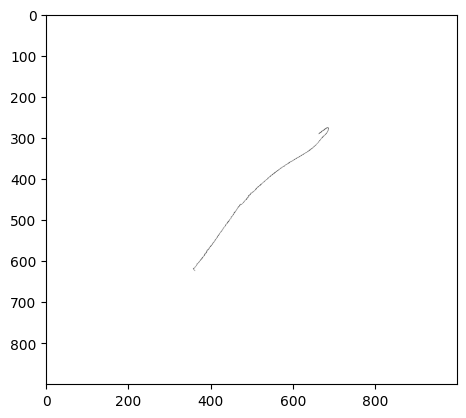

In [39]:
def get_line_mask(raster,line):
    """
    Get a mask of the line in the raster
    """
    line_mask = rasterize(
        [line.geometry],
        out_shape=raster.shape,
        transform=raster.transform,
        fill=0,
        dtype='uint8'
    )
    return line_mask

ID = "20170128T113321_bull_island"
example_raster_path = os.path.join(data_path, f"processed/aoi_crop/bull_island/2017/{ID}.tif")
example_raster = rasterio.open(example_raster_path)
veg_line = veg_lines[veg_lines['ID'] == ID].sample(n=1).iloc[0]

line_mask = get_line_mask(example_raster, veg_line)
print(line_mask.shape)
print(np.unique(line_mask))
plt.imshow(1-line_mask, cmap='gray')

In [ ]:
def get_points(line,m=100):
    """
    Convert a shapely geometry to a list of points
    """
   
    length = line.geometry.length

    # Get points every m meters along the line
    num_points = int(length / m)
    points = [line.geometry.interpolate(distance, normalized=False) 
            for distance in np.linspace(0, length, num_points)]

    return points

points = get_points(veg_line,m=100)
print(len(points))
print(points[0])

fig, ax = plt.subplots(1, 1, figsize=(10, 5))

rgb = example_raster.read()
rgb = utils.get_rgb(rgb ,contrast=0.3)
print(rgb.shape)
ax.imshow(rgb)

for point in points:
    utmx, utmy = point.x, point.y
    y, x = example_raster.index(utmx, utmy)
    ax.add_patch(plt.Circle((x, y), 1, color='blue', alpha=1))

54
POINT (688629.4920397468 5915250.198489088)


(900, 1000, 3)


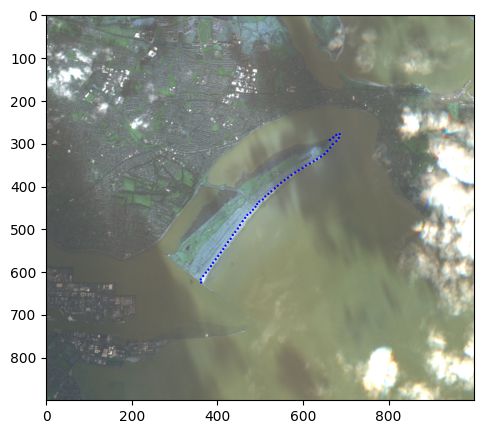

In [ ]:
import numpy as np
from rasterio.windows import Window


def get_crops(raster, mask, points,crop_size=144,augmentation=True):
    instances = []

    for point in points:
        # Get the pixel coordinates of the point
        utmx, utmy = point.x, point.y
        y, x = raster.index(utmx, utmy)

        # Get cropped window centered around the point
        window_x = x - crop_size // 2 
        window_y = y - crop_size // 2

        # Offset the window by a random amount within the crop size
        window_x += np.random.randint(-crop_size // 2, crop_size // 2) 
        window_y += np.random.randint(-crop_size // 2, crop_size // 2)

        # Define the window for cropping
        window = Window(window_x, window_y, crop_size, crop_size)
        
        # Read 4-band image crop
        img_crop = raster.read(window=window)[0:4, :, :]
        
        # Extract corresponding mask crop
        mask_crop = mask[window_y:window_y+crop_size, window_x:window_x+crop_size]
        # Add a channel dimension to the mask crop
        mask_crop = np.expand_dims(mask_crop, axis=0)
        
        if augmentation:
            # Randomly flip the image and mask crops
            if np.random.rand() > 0.5:
                img_crop = np.flip(img_crop, axis=1) #axis 0 is bands, axis 1 is y, axis 2 is x
                mask_crop = np.flip(mask_crop, axis=1)
            if np.random.rand() > 0.5:
                img_crop = np.flip(img_crop, axis=2)
                mask_crop = np.flip(mask_crop, axis=2)
            
            # Randomly rotate the image and mask crops
            angle = np.random.choice([0, 90, 180, 270])
            img_crop = np.rot90(img_crop, k=angle//90, axes=(1, 2))
            mask_crop = np.rot90(mask_crop, k=angle//90, axes=(1, 2))
        
        
        instance = np.concatenate([img_crop, mask_crop], axis=0)
        instances.append(instance)

    return instances

instances = get_crops(example_raster, line_mask, points,augmentation=True)
fig,ax = plt.subplots(10, 5, figsize=(10, 20))
ax = ax.flatten().flatten()
for i in range(49):
    img_crop = instances[i][0:3, :, :]
    mask_crop = instances[i][4:5, :, :][0]
    rgb = utils.get_rgb(img_crop, contrast=0.3)
    ax[i].imshow(rgb)
    ax[i].imshow(mask_crop, alpha=0.5, cmap='gray')
    ax[i].axis('off')

## Create dataset

In [55]:
# Get the in-location test IDs
locations = ["bull_island", "portmarnock", "portrane", "tramore"]
test_IDs_1 = []
for aoi in locations: 
    aoi_files = processed_files[processed_files["aoi"] == aoi]

    for year in aoi_files["year"].unique():
        year_files = aoi_files[aoi_files["year"] == year]
        test_IDs_1 += list(year_files["ID"].sample(n=1, random_state=42))

print(len(test_IDs_1))
print(test_IDs_1)

# Get the out-location test IDs
test_IDs_2 = processed_files[processed_files["aoi"] == "rossnowlagh"]["ID"].tolist()
print(len(test_IDs_2))
print(test_IDs_2)

train_IDs = processed_files[~processed_files["ID"].isin(test_IDs_1 + test_IDs_2)]["ID"].tolist()
print(len(train_IDs))


10
['20231022T114349_bull_island', '20190627T113321_bull_island', '20171129T113419_bull_island', '20190207T113321_portmarnock', '20171129T113419_portmarnock', '20240211T113311_portrane', '20220323T113321_portrane', '20200303T113311_portrane', '20190707T113321_portrane', '20240623T114351_tramore']
16
['20221211T114501_rossnowlagh', '20221204T115451_rossnowlagh', '20221116T114349_rossnowlagh', '20221007T114349_rossnowlagh', '20220922T114401_rossnowlagh', '20220910T115359_rossnowlagh', '20220905T115411_rossnowlagh', '20220813T114401_rossnowlagh', '20220811T115409_rossnowlagh', '20220722T115409_rossnowlagh', '20220607T115411_rossnowlagh', '20220604T114401_rossnowlagh', '20220523T115359_rossnowlagh', '20220408T115401_rossnowlagh', '20220326T114351_rossnowlagh', '20220319T115401_rossnowlagh']
89


In [74]:
for row in processed_files.iterrows():

    row = row[1]
    
    ID = row['ID']
    year = row['year']
    aoi = row['aoi']
    
    # Get raster 
    tif_filepath = os.path.join(data_path, f"processed/aoi_crop/{aoi}/{year}/{ID}.tif")

    if not os.path.exists(tif_filepath):
        print("File does not exist:", tif_filepath)
        continue

    raster =rasterio.open(tif_filepath)

    # Get number of lines from shape file
    veg_lines_id = veg_lines[veg_lines['ID'] == ID]
    lines = veg_lines_id['LINE'].unique()

    # We need to create a mask using all lines so they are present in all crops
    line_mask = np.zeros(raster.shape, dtype=np.uint8)
    for line in lines:
        veg_line = veg_lines_id[veg_lines_id['LINE'] == line]
        assert len(veg_line) == 1

        veg_line = veg_line.iloc[0] # Convert to series
        line_mask += get_line_mask(raster,veg_line)

    line_mask = np.clip(line_mask, 0, 1)  # Ensure mask is binary

    for line in lines:
        veg_line = veg_lines_id[veg_lines_id['LINE'] == line]
        veg_line = veg_line.iloc[0] # Convert to series

        points = get_points(veg_line,m=50)

        if ID in train_IDs:
            save_dir = os.path.join(data_path, "SIVE/training")
            instances = get_crops(raster, line_mask, points,augmentation=True)

        if ID in test_IDs_1:
            save_dir = os.path.join(data_path, "SIVE/test_1")
            instances = get_crops(raster, line_mask, points,augmentation=False)

        elif ID in test_IDs_2:
            save_dir = os.path.join(data_path, "SIVE/test_2")
            instances = get_crops(raster, line_mask, points,augmentation=False)

        os.makedirs(save_dir, exist_ok=True)

        assert len(instances) > 0
        print("ID:", ID, " | ", int(line), " | ", len(instances))

        # Save instances
        filename = f"{ID}_line{int(line)}"
        for i, instance in enumerate(instances):
            assert instance.shape == (5, 144, 144)
            save_path = os.path.join(save_dir, f"{filename}_{i}.npy")
            np.save(save_path, instance)
 

ID: 20241222T113409_tramore  |  1  |  119
ID: 20241127T113421_tramore  |  1  |  119
ID: 20241120T114401_tramore  |  1  |  119
ID: 20241021T114351_tramore  |  1  |  119
ID: 20241011T114351_tramore  |  1  |  119
ID: 20240916T114349_tramore  |  1  |  119
ID: 20240814T113319_tramore  |  1  |  119
ID: 20240809T113321_tramore  |  1  |  119
ID: 20240728T114349_tramore  |  1  |  119
ID: 20240623T114351_tramore  |  1  |  119
ID: 20240519T114349_tramore  |  1  |  119
ID: 20240511T113321_tramore  |  1  |  119
ID: 20240421T113321_tramore  |  1  |  119
ID: 20240330T114349_tramore  |  1  |  119
ID: 20240216T113319_tramore  |  1  |  119
ID: 20221211T114501_rossnowlagh  |  1  |  53
ID: 20221204T115451_rossnowlagh  |  1  |  53
ID: 20221116T114349_rossnowlagh  |  1  |  53
ID: 20221007T114349_rossnowlagh  |  1  |  53
ID: 20220922T114401_rossnowlagh  |  1  |  53
ID: 20220910T115359_rossnowlagh  |  1  |  53
ID: 20220905T115411_rossnowlagh  |  1  |  53
ID: 20220813T114401_rossnowlagh  |  1  |  53
ID: 202208

Number of files: 8460
Positive pixels in test set: 6762
Total pixels in test set: 1036800
Postive weight: 153.32741792369123


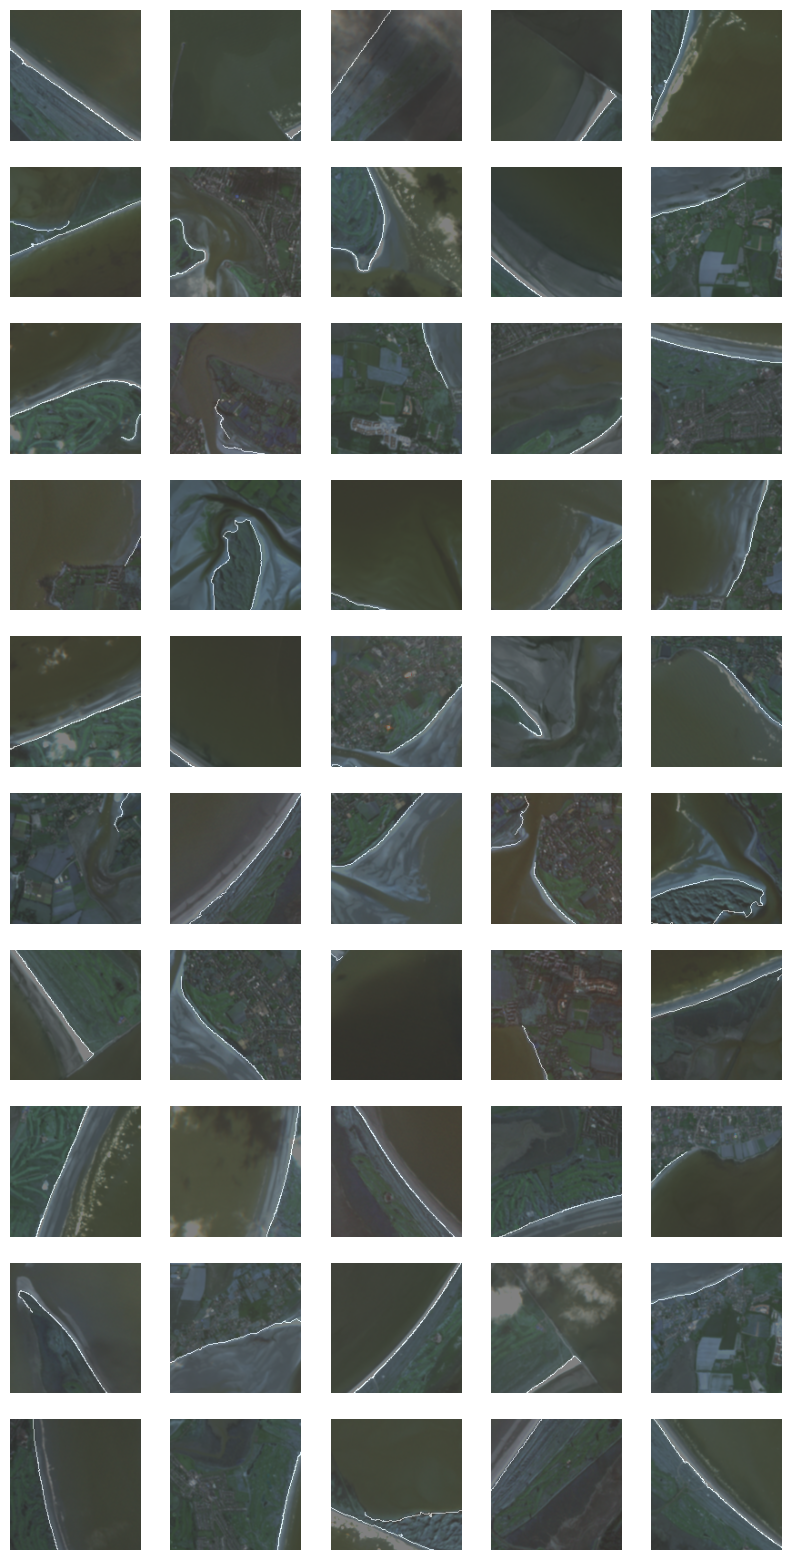

In [75]:
# Sense check training
test_files = glob.glob(os.path.join(data_path, "SIVE/training", "*.npy"))
print("Number of files:", len(test_files))

fig,ax = plt.subplots(10, 5, figsize=(10, 20))
ax = ax.flatten().flatten()
positive = 0
total = 0
for i in range(50):
    instance = np.load(random.choice(test_files))
    positive += np.sum(instance[4] == 1)
    total += instance[4].shape[0] * instance[4].shape[1]
    img_crop = instance[0:4, :, :]
    mask_crop = instance[4]
    rgb = utils.get_rgb(img_crop, contrast=0.3)
    ax[i].imshow(rgb)
    ax[i].imshow(mask_crop, alpha=0.5, cmap='gray')
    ax[i].axis('off')

print("Positive pixels in test set:", positive)
print("Total pixels in test set:", total)
print("Postive weight:", total/positive)

Number of test files: 848
Positive pixels in test set: 5626
Total pixels in test set: 1036800
Postive weight: 184.28723782438678


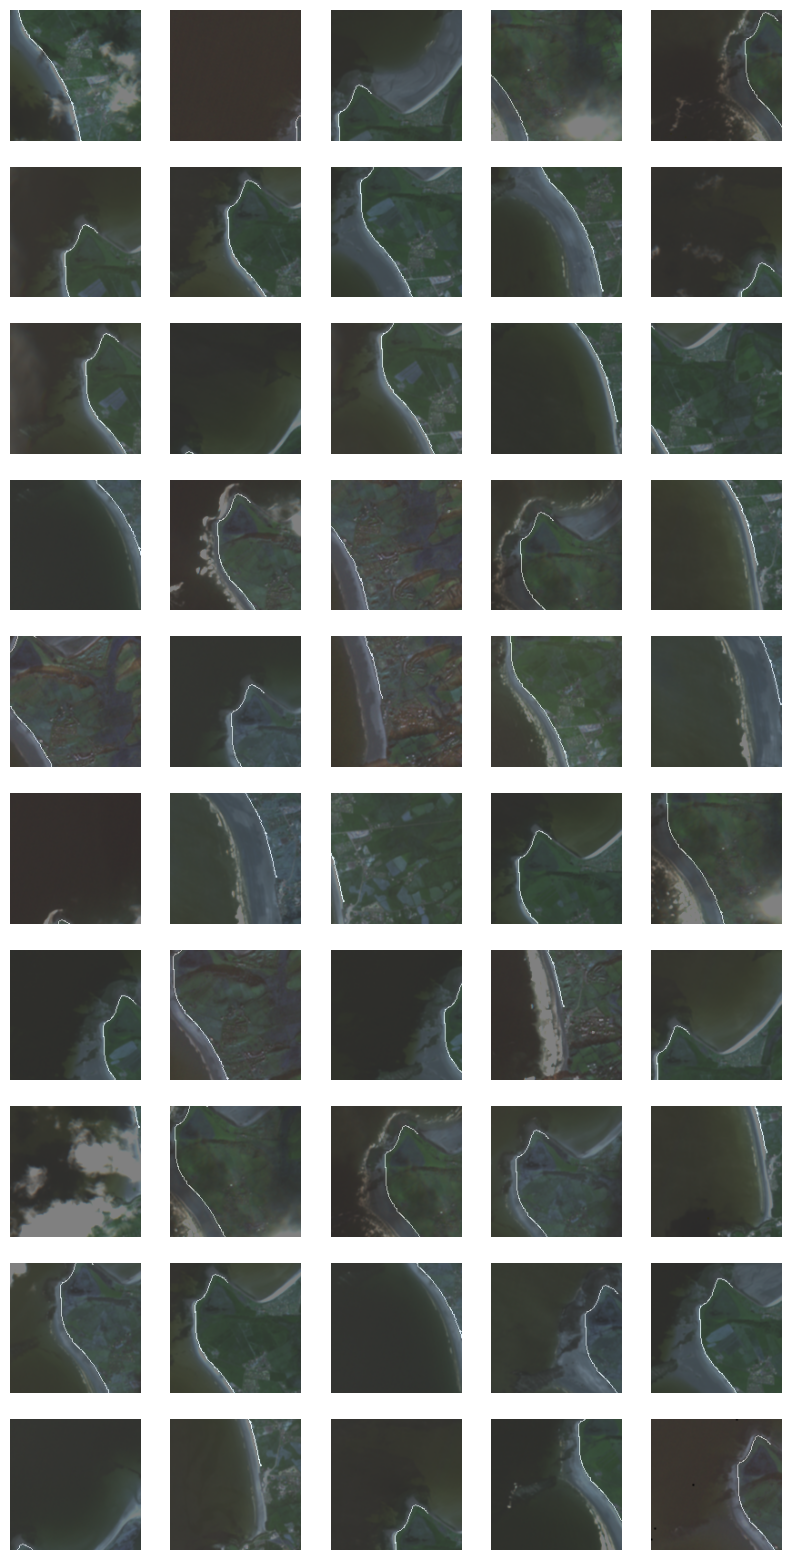

In [76]:
# Sense check training
test_files = glob.glob(os.path.join(data_path, "SIVE/test_2", "*.npy"))
print("Number of test files:", len(test_files))

fig,ax = plt.subplots(10, 5, figsize=(10, 20))
ax = ax.flatten().flatten()
positive = 0
total = 0
for i in range(50):
    instance = np.load(random.choice(test_files))
    positive += np.sum(instance[4] == 1)
    total += instance[4].shape[0] * instance[4].shape[1]
    img_crop = instance[0:4, :, :]
    mask_crop = instance[4]
    rgb = utils.get_rgb(img_crop, contrast=0.3)
    ax[i].imshow(rgb)
    ax[i].imshow(mask_crop, alpha=0.5, cmap='gray')
    ax[i].axis('off')

print("Positive pixels in test set:", positive)
print("Total pixels in test set:", total)
print("Postive weight:", total/positive)